# R-VGA in a logistic regression problem

In [1]:
%load_ext autoreload
%autoreload 2

In [147]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [3]:
%config InlineBackend.figure_format = "retina"

In [57]:
n_samples = 500
X, y, cls = make_biclusters((n_samples, 2), 2, noise=1.0, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

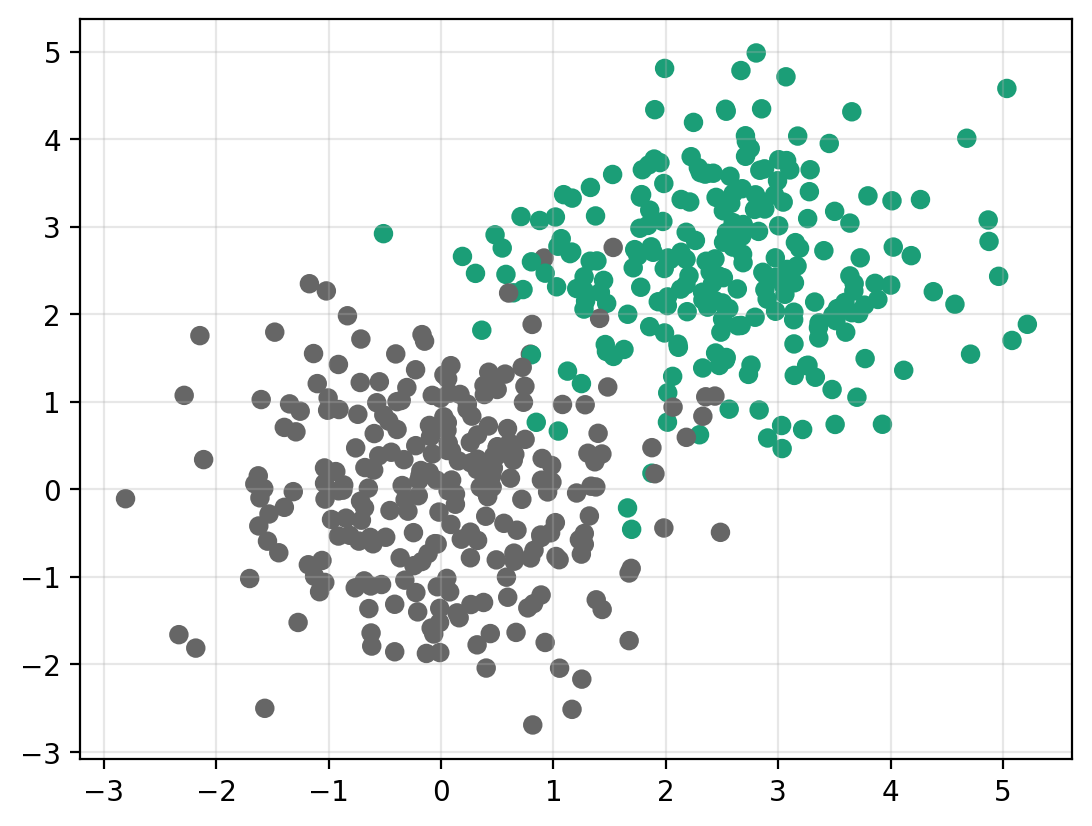

In [58]:
plt.scatter(*X.T, c=y, cmap="Dark2")
plt.grid(alpha=0.3)

In [110]:
n_samples = 500
dim = 2
X, y, cls = make_biclusters((n_samples, dim), 2, noise=1.2, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

In [111]:
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

rvga_filter = rvga.BernoulliRVGA(apply_fn)

key = jax.random.PRNGKey(314)
Phi = jnp.c_[jnp.ones(n_samples), X]
bel_init = rvga_filter.init_bel(jnp.zeros(dim + 1))

In [112]:
_, mean_hist = rvga_filter.scan(key, bel_init, y[:, None], Phi)

In [113]:
preds = jnp.einsum("tm,tm->t", mean_hist, Phi)
preds = jax.nn.sigmoid(preds).round()
(preds == y).mean()

Array(0.93200004, dtype=float32)

In [115]:
jnp.ones((1, 20, 20)).shape

(1, 20, 20)

In [116]:
x = jnp.linspace(-3, 5, 20)
Z = jnp.mgrid[-3:5:20j,-3:5:20j]
S = jnp.concat([jnp.ones((1, 20, 20)), Z], axis=0)

S = jax.nn.sigmoid(jnp.einsum("dij,d->ij", S, mean_hist[-1]))

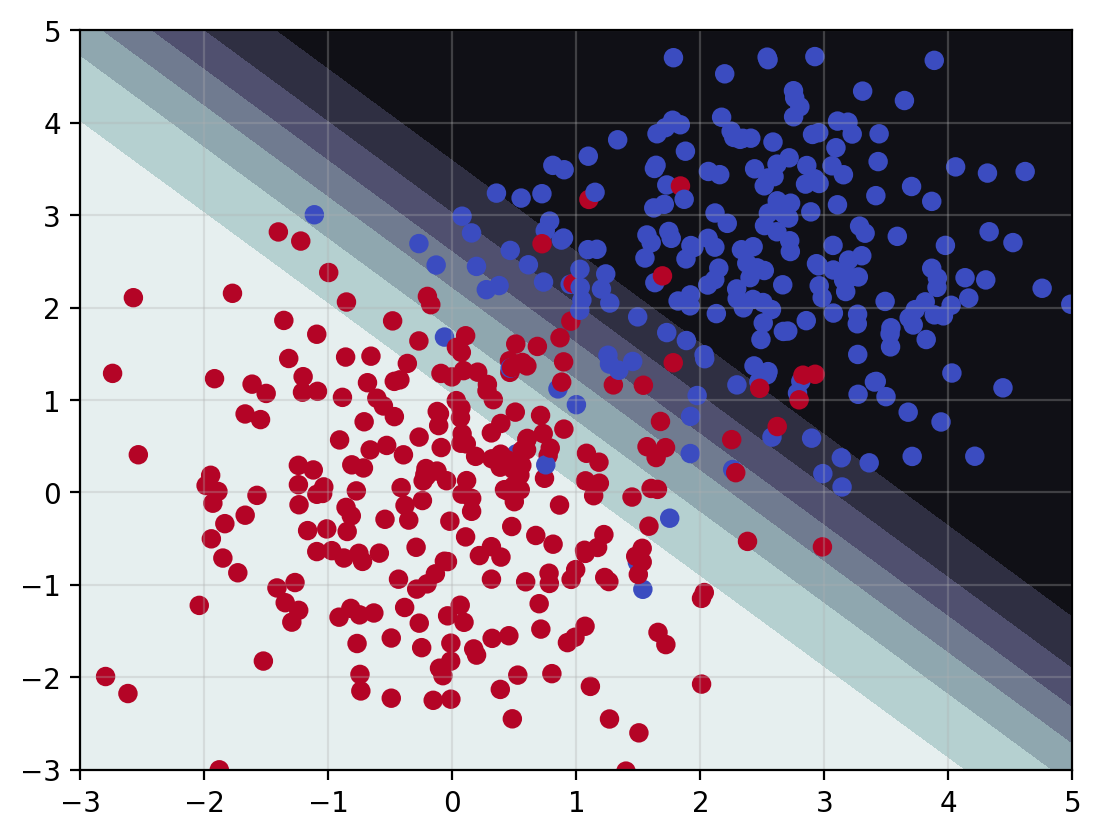

In [117]:
plt.contourf(x, x, S, cmap="bone")
plt.scatter(*X.T, c=y, cmap="coolwarm")
plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.grid(alpha=0.3)

## Increasing dimension

In [242]:
n_samples = 500
dim = 50
X, y, cls = make_biclusters((n_samples, dim), 2, noise=1.2, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

In [290]:
X = jnp.array(X)
y = jnp.array(y)

In [301]:
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

rvga_filter = rvga.BernoulliRVGA(apply_fn, n_inner=5, n_samples=10)

Phi = jnp.c_[jnp.ones(n_samples), X]
bel_init = rvga_filter.init_bel(jnp.zeros(dim + 1))

In [302]:
key = jax.random.PRNGKey(314)
n_runs = 20

@jax.vmap
def run_and_pred(key):
    _, mean_hist = rvga_filter.scan(key, bel_init, y[:, None], Phi)
    
    preds = jnp.einsum("tm,tm->t", mean_hist[:-1], Phi[1:])
    preds = jax.nn.sigmoid(preds).round()
    return preds


In [309]:
keys = jax.random.split(key, n_runs)
preds = run_and_pred(keys)
preds = np.array(preds)

In [310]:
np.nanmean(preds, axis=1)

array([0.5897436 , 0.5       , 0.49499   , 0.496994  , 0.49098197,
       0.5897436 , 0.54545456, 0.4729459 , 0.5897436 , 0.5641026 ,
       0.5897436 , 0.4769539 , 0.5641026 , 0.5897436 , 0.49298596,
       0.48897797, 0.61538464, 0.48897797, 0.5181818 , 0.5897436 ],
      dtype=float32)

In [299]:

(preds == y[1:]).mean()

Array(0.43136272, dtype=float32)

In [ ]:
pd.Series(preds == y[1:]).expanding(20).mean().plot()
plt.grid(alpha=0.3)